# ChromProcess Introduction Part 1

This series of notebooks runs through one possible way of using the code contained in ChromProcess, thereby introducing its core functionality. These notebooks should work fine in the folder they are found in if ChromProcess can be imported (see installation instructions). ChromProcessIntroduction_1 shows how chromatograms and their associated data can be loaded and how peak information can be extracted from them and stored.

# What is ChromProcess?

ChromProcess is a collection of Python functions and objects which provide a framework for manipulating sets of chromatographic data.

There are several types of information required to reproducibly assign and/or quantify chromatographic peaks. ChromProcess is one way of interfacing these various information sources. By 'interfacing', I mean placing the data in in an appropriate format and organisational structure.

# Source Files

## Experiment-specific files

Experimental data and 'metadata' (primary data), go in the front of the analysis pipeline. Files containing information about the experiment should not be altered during analysis. Primary data files consist of several chromatographic data files (as of writing ChromProcess can load `.cdf`, `.txt` or `.csv` format) and a conditions file (`.toml` format, `.csv` format is possible but deprecated). The chromatographic data files should be named in such a way that they can be sorted programatically. For example, the sequence `chrom_001.csv`, `chrom_002.csv`, `chrom_003.csv` would be appropriate. The structure and contents of an example conditions file are shown below.

In [14]:
import csv

with open('../Sample_analysis/Example/ExperimentalData/example_conditions.toml', "r") as f:
    text = f.read()
    
print(text)

# A code for the data set
Dataset = "example_dataset_name"
# Values of the series covered by the chromatograms
Series_values = [10.0, 20.0, 30.0]
# Unit for the chromatogram series.
Series_unit = "time/ s"
# Not yet used: can be used to ensure correct mapping between files and series values.
Chromatogram_order = ["chrom_001.csv", "chrom_002.csv", "chrom_003.csv"]

[conditions]
# Condition_name = [magnitude, unit]
# Condition_name = [[magnitude, magnitude, magnitude, ...], unit]
dihydroxyacetone = [2.0, "M"]
formaldehyde = [2.0, "M"]
NaOH = [0.12, "M"]
CaCl2 = [0.06, "M"]
water = [0.0, "M"]


# A code for the data set
Dataset = "example_dataset_name"
# Values of the series covered by the chromatograms
Series_values = [10.0, 20.0, 30.0]
# Unit for the chromatogram series.
Series_unit = "time/ s"
# Not yet used: can be used to ensure correct mapping between files and series values.
Chromatogram_order = ["chrom_001.csv", "chrom_002.csv", "chrom_003.csv"]

[conditions]
# Condition_name = [m

- Dataset: Reference code for the experiment
- Series_values: ordered values associated with the chromatograms (e.g. timepoints)
- Series_unit: the units for series_values; format: {name}/ {unit}
- \[conditions\]: a set of conditions for the experiment.
    - the units and values are placed in a list.

Keeping track of the operations performed on the primary data is an important component of a reproducible pipeline. To record and input details of analysis operations, an analysis details file (`.csv`) is also included alongside the primary data. The structure and contents of an example analysis file are shown below.

In [15]:
with open('../Sample_analysis/Example/Analysis/example_analysis_details.toml', "r") as f:
    text = f.read()
    
print(text)

# A code name for the data.
Dataset = "example_dataset_name"

[Method_information]
# Information on the chromatographic method used.
Method = "GCMS"
Instrument = "GCv Agilent/JEOL"
Instrument_method = "Method 5"
Calibration_model = "quadratic"
Calibration_file = "2020_03_16_GCMS_Calibrations.csv"
Derivatisation_method = '''
Reaction samples (35 μL) were flash-frozen in liquid nitrogen and freeze-dried
overnight to give dry to oily residues. To each sample was added a solution of
O-ethylhydroxylamine hydrochloride in pyridine (75 μL, 20 g L^−1^). A solution
of dodecane and tetradecane (100 μL, 1.6 mM each in pyridine) was then added to
each sample. The samples were then shaken at 70 °C for 30 minutes. After
cooling to room temperature, N,O-bis(trimethylsilyl)trifluoroacetamide (25 μL)
was added to each sample. The samples were again shaken at 70 °C for 30
minutes. The samples were then cooled to room temperature, followed by
centrifugation (3-5 min, 10,000 rpm). The supernatants were de

Additionally, a local assignments file (initially an empty `.csv` file) can be added to the project. These files can be arranged in folders however you wish. Whichever organisation scheme used must be systematic. An example struture is shown below:

## Files applicable to several experiments

Calibration information for an instrument may be applicable to one or more sets of data. This information can therefore be stored separately from the primary data. Alternatively, a copy of a calibration file can be included within the directory of each experiment. This method has the benefit of providing a more unambiguous association of the data to the calibration. On the other hand, if changes must be made to a calibration file (e.g. adding a new calibration for a compound), multiple files must be updated which may be more labour-intensive and error-prone. Either way, creating a file which assigns each experiment to a calibration file (including paths to each file) is beneficial, as is creating a workflow for updating analyses in response to changes to the source files.

# Overview of an Example Analysis Pipeline

The first step is to create peak table files containing peak positions, boundaries and integrals for each chromatogram. Each chromatogram is loaded in as a `Chromatogram` object. The analysis and conditions files are also loaded as `Analysis_Information` and `Experiment_Conditions` objects, respectively. Information in the analysis file is used to find peaks in each chromatogram before each peak is integrated. The `Chromatogram` can then be used to create a peak table with associated condition information, if required.

Before beginning the analysis, the chromatograms should be inspected and information should be input into the analysis file as appropriate (regions, concentrations, etc.). First, the source files are directly converted into objects:

In [16]:
import os
from ChromProcess.Loading import chrom_from_csv

chromatogram_directory = '../Sample_analysis/Example/ExperimentalData/ExampleChromatograms'
chromatogram_files = os.listdir(chromatogram_directory)
chromatogram_files.sort()
chroms = []
for f in chromatogram_files:
    chroms.append(chrom_from_csv(f'{chromatogram_directory}/{f}'))

Before proceeding with the analysis, the chromatograms are inspected for quality (up to you as a scientist!) and for regions to be selected for peak picking. The plots can be generated by any plotting method that you are comfortable with. Below is an example using `matplotlib`.

When picking regions for peak picking, the idea is to select regions in the chromatogram in which the peaks have similar intensities. An arbitrary number of boundaries can be input. At one extreme, a single boundary for the beginning and end of the chromatogram can be use. At the other logical extreme, boundaries for individual peaks can be input. Bear in mind that the current implementation of peak picking does not account for retention time drift between chromatograms, and the regions passed to each chromatogram are the same. Therefore, 'manual' peak picking in the manner may not be accurate.

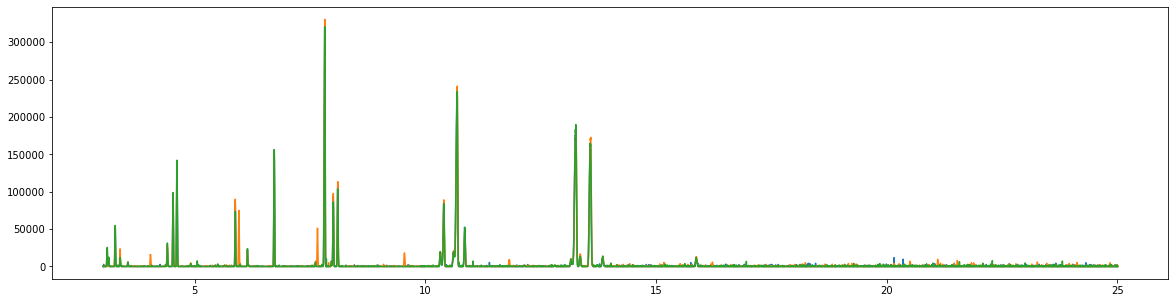

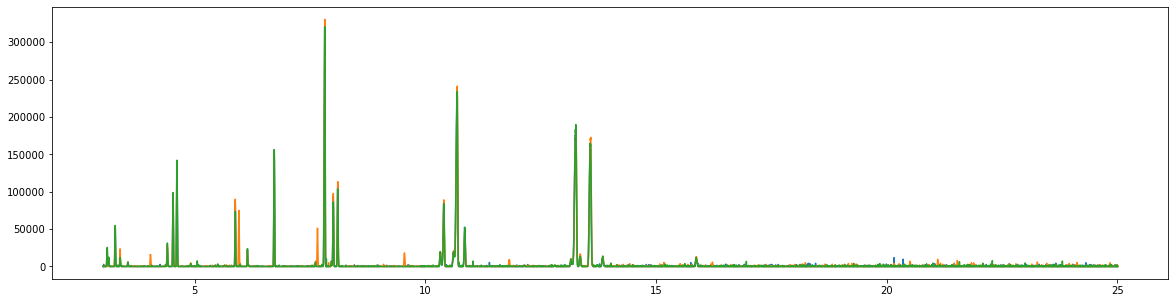

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20,5))
for c in chroms:
    ax.plot(c.time, c.signal, label = c.filename)
plt.show()

In [18]:
from ChromProcess.Loading import analysis_from_toml
from ChromProcess.Loading import conditions_from_toml
conditions_file = '../Sample_analysis/Example/ExperimentalData/example_conditions.toml'
analysis_file = '../Sample_analysis/Example/Analysis/example_analysis_details.toml'
conditions = conditions_from_toml(conditions_file)
analysis = analysis_from_toml(analysis_file)

Next, a peak for the internal standard is picked using information in `analysis` (the function modifies the chromatogram object passed to it by inserting the internal standard information, currently, only one internal standard is supported). This step assumes that the internal standard selected in the chromatograms is a single peak, with no peaks originating from the sample overlapping it (within the `analysis.internal_standard_region`).

In [19]:
from ChromProcess.Processing import internal_standard_integral

is_start = analysis.internal_standard_region[0]
is_end = analysis.internal_standard_region[1]
for c in chroms:
    internal_standard_integral(c, is_start, is_end)

Information from `analysis` (originating in the analysis information file described above) is again used to pick peaks in defined regions of each chromatogram. The functions add peak information into chromatograms.

In [20]:
from ChromProcess.Processing import find_peaks_in_region
from ChromProcess.Processing import add_peaks_to_chromatogram
from ChromProcess.Processing import integrate_chromatogram_peaks

threshold = analysis.peak_pick_threshold
for chrom in chroms:
    for reg in analysis.regions:
            peaks = find_peaks_in_region(
                                            chrom, 
                                            reg[0], 
                                            reg[1], 
                                            threshold = threshold 
                                        )
            add_peaks_to_chromatogram(peaks, chrom)
            integrate_chromatogram_peaks(chrom)

Inspecting peak picking:

chrom_001.csv 9


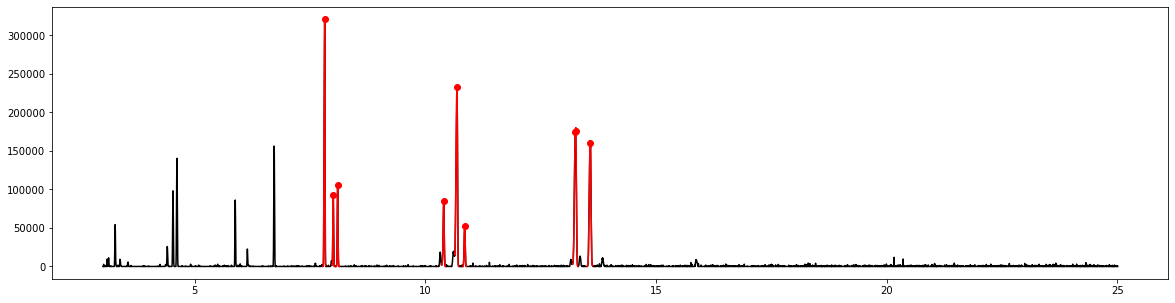

chrom_001.csv 9


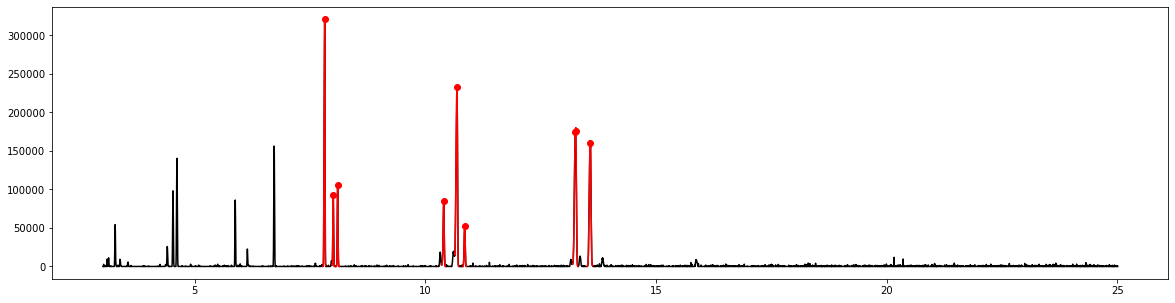

In [21]:
test_chromatogram = chroms[0]

time = test_chromatogram.time
signal = test_chromatogram.signal

fig, ax = plt.subplots(figsize = (20,5))
ax.plot(time, signal, c = 'k', zorder = 0)
for c,pk in enumerate(test_chromatogram.peaks):
    peak = test_chromatogram.peaks[pk]
    idx = peak.indices
    ax.plot(time[idx], signal[idx], c= 'r', zorder  = 1)
    ax.scatter(peak.retention_time, peak.height, c= 'r', zorder  = 1)
print(test_chromatogram.filename, len(test_chromatogram.peaks))
plt.show()

Peaks collections can then be written directly from each `Chromatogram` whilst inserting information from conditions files if required. Note here that the ordering of chromatograms must be the same as the order or series values in the conditions file.

In [22]:
import os
# Output peak collection
peak_collection_directory = '../Sample_analysis/Example/ExperimentalData/ExamplePeakCollections'

os.makedirs(peak_collection_directory, exist_ok = True)
for c,v in zip(chroms, conditions.series_values):
    c.write_peak_collection(filename = f'{peak_collection_directory}/{c.filename}',
                        header_text = f"{conditions.series_unit},{v}\n",
                        )

It make also be convenient to store the chromatographic signals in a simple `.csv` or `.json` format for use with other software. These files can be created using one of Chromatogram's methods:

In [23]:
chromatogram_output_folder = '../Sample_analysis/Example/ExperimentalData/ChromatogramCSV'
for c in chroms:
    c.write_to_csv(filename = f'{chromatogram_output_folder}/{c.filename}')

In [24]:
chromatogram_output_folder = '../Sample_analysis/Example/ExperimentalData/ChromatogramCSV'
for c in chroms:
    c.write_to_json(filename = f'{chromatogram_output_folder}/{c.filename[:-4]}.json')

Peaks can also be loaded from peak_collection csv files.

In [25]:
from ChromProcess.Loading import peak_collection_from_csv

for c, chrom in enumerate(chroms, 1):
    peak_file = f"{peak_collection_directory}/{chrom.filename}"
    peak_collection = peak_collection_from_csv(peak_file)
    add_peaks_to_chromatogram(peak_collection.peaks, chrom)

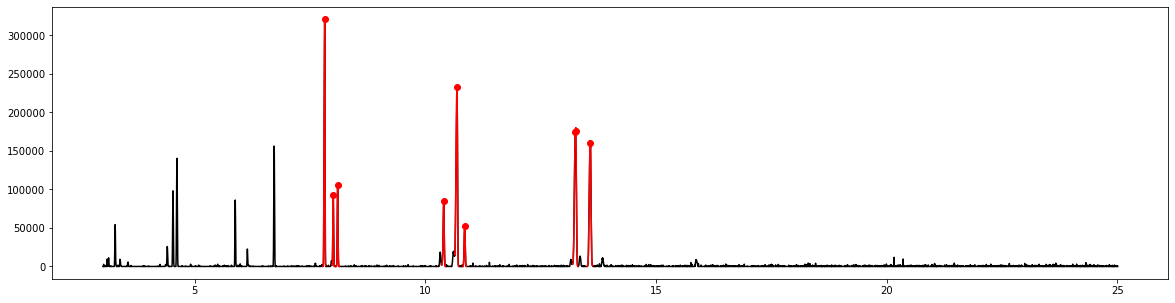

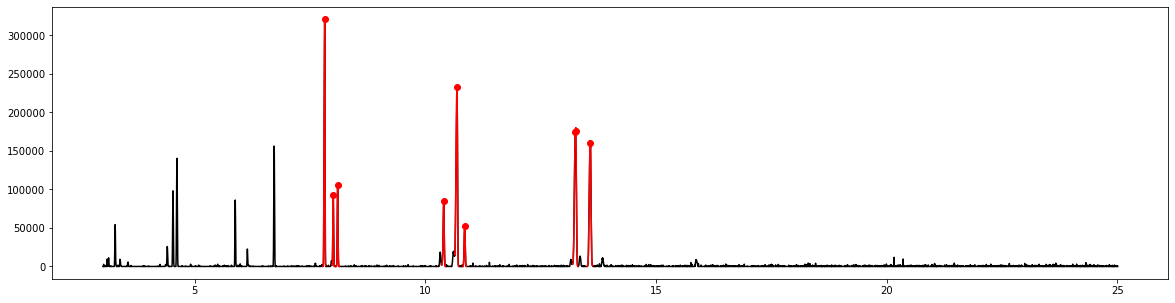

In [26]:
test_chromatogram = chroms[0]

time = test_chromatogram.time
signal = test_chromatogram.signal

fig, ax = plt.subplots(figsize = (20,5))
ax.plot(time, signal, c = 'k', zorder = 0)
for c,pk in enumerate(test_chromatogram.peaks):
    peak = test_chromatogram.peaks[pk]
    idx = peak.indices
    ax.plot(time[idx], signal[idx], c= 'r', zorder  = 1)
    ax.scatter(peak.retention_time, peak.height, c= 'r', zorder  = 1)

plt.show()

That concludes this tutorial notebook. The next tutorial notebook will deal with processing the peak tables into series data.